In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Masking
from tensorflow.keras.utils import to_categorical, pad_sequences
import matplotlib.pyplot as plt

print("Libraries imported successfully!")
print("TensorFlow Version:", tf.__version__)

Libraries imported successfully!
TensorFlow Version: 2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/cmi-detect-behavior-with-sensor-data/"
try:
    df_train = pd.read_csv(DATA_PATH + "train.csv")
    print("Training data loaded successfully!")
    print("Shape of the data:", df_train.shape)
    df_train.head()
except FileNotFoundError:
    print("ERROR: Could not find 'train.csv'. Please check your DATA_PATH.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data loaded successfully!
Shape of the data: (574945, 341)


In [ ]:
# these features are good because rf.get_feature_importances_ says so for the random forest mode
# and they are the only ones that are not NaN in the dataset
# refer the simple ML model notebook for this
imu_features = [
    'acc_x', 'acc_y', 'acc_z',
    'rot_w', 'rot_x', 'rot_y', 'rot_z'
]
target_col = 'gesture'

label_encoder = LabelEncoder()
df_train['gesture_encoded'] = label_encoder.fit_transform(df_train[target_col])
n_classes = len(label_encoder.classes_)
print(f"Found {n_classes} unique gestures.")

df_train[imu_features] = df_train[imu_features].ffill().bfill()

scaler = StandardScaler()
df_train[imu_features] = scaler.fit_transform(df_train[imu_features])
print("Features have been scaled.")

sequences = []
labels = []
grouped = df_train.groupby('sequence_id')

for name, group in grouped:
    sequences.append(group[imu_features].values)
    labels.append(group['gesture_encoded'].iloc[0]) # All labels in a group are the same

print(f"\nProcessed data into {len(sequences)} sequences.")

Found 18 unique gestures.
Features have been scaled.

Processed data into 8151 sequences.


In [ ]:
# Find the length of each sequence
sequence_lengths = [len(s) for s in sequences]

# Set the maximum sequence length to the 95th percentile
# This helps to avoid excessive padding while still covering most sequences
MAX_LENGTH = int(np.percentile(sequence_lengths, 95))
print(f"Max sequence length will be set to: {MAX_LENGTH}")

X = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post', dtype='float32')
y = np.array(labels)

y_categorical = to_categorical(y, num_classes=n_classes)

print("\nData shape after padding (Sequences, Timesteps, Features):", X.shape)
print("Labels shape after one-hot encoding (Sequences, Classes):", y_categorical.shape)

Max sequence length will be set to: 127

Data shape after padding (Sequences, Timesteps, Features): (8151, 127, 7)
Labels shape after one-hot encoding (Sequences, Classes): (8151, 18)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

print("Data split into training and validation sets:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


model = Sequential([
    Masking(mask_value=0., input_shape=(MAX_LENGTH, len(imu_features))),

    Bidirectional(LSTM(64, return_sequences=False)), # return_sequences=False because it is stacking

    Dense(32, activation='relu'),

    # The final output layer
    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

print("\nStarting model training...")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20, # You can increase this for better results
    batch_size=32
)
print("Model training complete!")

Data split into training and validation sets:
X_train shape: (6520, 127, 7)
X_val shape: (1631, 127, 7)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 127, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,586 (162.45 KB)

 Trainable params: 41,586 (162.45 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - accuracy: 0.1309 - loss: 2.6647 - val_accuracy: 0.2226 - val_loss: 2.2150
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 35s 173ms/step - accuracy: 0.2477 - loss: 2.1414 - val_accuracy: 0.2710 - val_loss: 2.0417
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.2855 - loss: 1.9780 - val_accuracy: 0.2882 - val_loss: 1.9673
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.3162 - loss: 1.9143 - val_accuracy: 0.3066 - val_loss: 1.9329
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 34s 168ms/step - accuracy: 0.3384 - loss: 1.8337 - val_accuracy: 0.3072 - val_loss: 1.8927
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.3486 - loss: 1.7852 - val_accuracy: 0.3372 - val_loss: 1.8411
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.3721 - loss: 1.7129 - val_accuracy: 0.3274 - val_loss: 1.8112
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step 

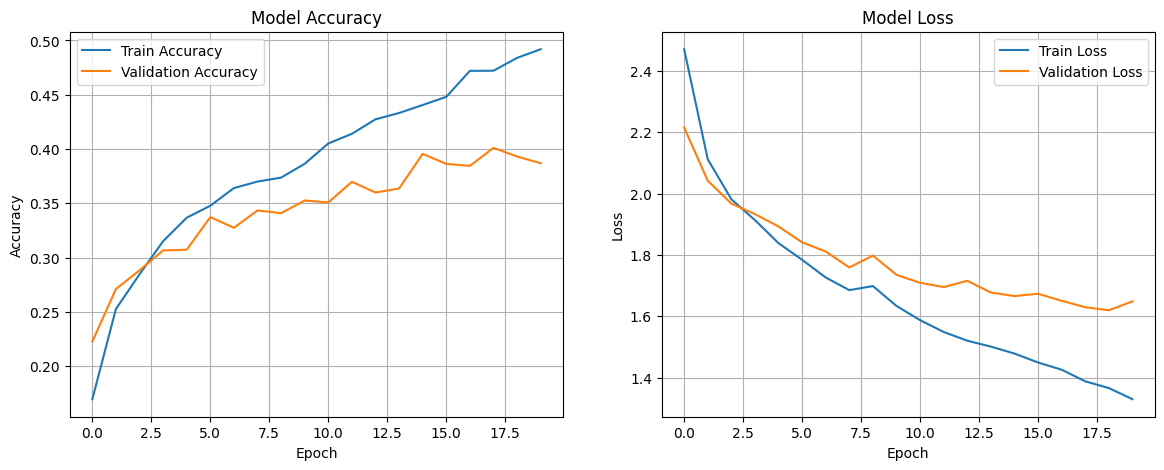

In [15]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)

    plt.show()

plot_history(history)

In [ ]:
# second part
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial.transform import Rotation as R
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Bidirectional, GRU, Dense, Dropout, Concatenate,
    Conv1D, BatchNormalization, Activation, MaxPooling1D,
    GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization, Add
)
from tensorflow.keras.utils import to_categorical, pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import gc # Garbage Collector


In [ ]:
# Now time to feature engineer
def remove_gravity_from_acc(acc_data, rot_data):
    """Calculates linear acceleration by removing the gravity component. useful in gyro and accelerometer data.
    Reference: https://www.researchgate.net/publication/394490866_Human_Activity_Detection_Using_Accelerometer_and_Gyroscope_Data"""
    gravity = np.array([0, 0, 9.81]) # Standard gravity
    linear_accel = np.zeros_like(acc_data)

    for i in range(len(acc_data)):
        quat = rot_data[i]
        if np.all(np.isfinite(quat)) and not np.all(quat == 0):
            try:
                rotation = R.from_quat(quat)
                gravity_in_sensor_frame = rotation.apply(gravity, inverse=True)
                linear_accel[i] = acc_data[i] - gravity_in_sensor_frame
            except ValueError:
                linear_accel[i] = acc_data[i] # Fallback
        else:
            linear_accel[i] = acc_data[i] # Fallback
    return linear_accel


def calculate_angular_velocity_from_quat(rot_data, time_delta=1/200.0):
    """Calculates angular velocity 
    Angular velocity is a nice feature to have especially when working with gyroscope data.
    It gives us the rate of change of orientation which can be useful for detecting certain gestures"""
    angular_vel = np.zeros((len(rot_data), 3))

    for i in range(len(rot_data) - 1):
        q1 = rot_data[i]
        q2 = rot_data[i+1]
        if np.all(np.isfinite(q1)) and not np.all(q1 == 0) and \
           np.all(np.isfinite(q2)) and not np.all(q2 == 0):
            try:
                r1 = R.from_quat(q1)
                r2 = R.from_quat(q2)
                # Calculate the relative rotation
                delta_rotation = r1.inv() * r2
                # The rotation vector's magnitude is the angle of rotation
                # Divide by time to get angular velocity
                angular_vel[i] = delta_rotation.as_rotvec() / time_delta
            except ValueError:
                pass # Remains zero
    return angular_vel

print("Feature engineering functions are ready.")

Feature engineering functions are ready.


In [ ]:
# Handle any initial NaNs before feature engineering
df_train.ffill(inplace=True)
df_train.bfill(inplace=True)

print("Creating new features...")
acc_values = df_train[['acc_x', 'acc_y', 'acc_z']].values
rot_values = df_train[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values # Scipy expects x,y,z,w

linear_acc = remove_gravity_from_acc(acc_values, rot_values)
angular_vel = calculate_angular_velocity_from_quat(rot_values)

df_train[['linear_acc_x', 'linear_acc_y', 'linear_acc_z']] = linear_acc
df_train[['angular_vel_x', 'angular_vel_y', 'angular_vel_z']] = angular_vel
print("Done.")

# Select our richer feature set
features = [
    'acc_x', 'acc_y', 'acc_z',
    'rot_w', 'rot_x', 'rot_y', 'rot_z',
    'linear_acc_x', 'linear_acc_y', 'linear_acc_z', 
    'angular_vel_x', 'angular_vel_y', 'angular_vel_z' #New feats
]
target_col = 'gesture'

label_encoder = LabelEncoder()
df_train['gesture_encoded'] = label_encoder.fit_transform(df_train[target_col])
n_classes = len(label_encoder.classes_)
print(f"\nFound {n_classes} unique gestures.")

scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
print("Features have been scaled.")

sequences = []
labels = []
grouped = df_train.groupby('sequence_id')

for name, group in grouped:
    sequences.append(group[features].values)
    labels.append(group['gesture_encoded'].iloc[0])

print(f"\nProcessed data into {len(sequences)} sequences.")

Creating new features...
Done.

Found 18 unique gestures.
Features have been scaled.

Processed data into 8151 sequences.


In [ ]:
# padding code
# this is done to ensure all sequences have the same length
# This is important for LSTM input
sequence_lengths = [len(s) for s in sequences]
MAX_LENGTH = int(np.percentile(sequence_lengths, 95))
print(f"Max sequence length will be set to: {MAX_LENGTH}")

X = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post', dtype='float32')
y = np.array(labels)
y_categorical = to_categorical(y, num_classes=n_classes)

print("\nData shape after padding (Sequences, Timesteps, Features):", X.shape)
print("Labels shape after one-hot encoding (Sequences, Classes):", y_categorical.shape)

Max sequence length will be set to: 127

Data shape after padding (Sequences, Timesteps, Features): (8151, 127, 13)
Labels shape after one-hot encoding (Sequences, Classes): (8151, 18)


In [ ]:
# more complex model building
X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y
)

# Build the upgraded model
model = Sequential([
    Masking(mask_value=0., input_shape=(MAX_LENGTH, len(features))),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Stop training if the validation loss not improving for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Reduce the learning rate if training plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train the model with the callbacks
print("\nStarting model training with smart callbacks...")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr] # Add callbacks
)
print("Model training complete!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 127, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 123, 64)        │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 61, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 61, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,474 (857.32 KB)

 Trainable params: 219,474 (857.32 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training with smart callbacks...
Epoch 1/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 48s 212ms/step - accuracy: 0.1299 - loss: 2.6444 - val_accuracy: 0.2177 - val_loss: 2.2582 - learning_rate: 0.0010
Epoch 2/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 81s 209ms/step - accuracy: 0.2216 - loss: 2.2282 - val_accuracy: 0.2704 - val_loss: 2.0099 - learning_rate: 0.0010
Epoch 3/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - accuracy: 0.2822 - loss: 1.9803 - val_accuracy: 0.2961 - val_loss: 1.9381 - learning_rate: 0.0010
Epoch 4/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 79s 196ms/step - accuracy: 0.2984 - loss: 1.8947 - val_accuracy: 0.2998 - val_loss: 1.9049 - learning_rate: 0.0010
Epoch 5/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 43s 210ms/step - accuracy: 0.3062 - loss: 1.8312 - val_accuracy: 0.3127 - val_loss: 1.8236 - learning_rate: 0.0010
Epoch 6/100
204/204 ━━━━━━━━━━━━━━━━━━━━ 43s 212ms/step - accuracy: 0.3364 - loss: 1.7577 - val_accuracy: 0.3225 - val_loss: 1.8125 - learning_rate: 0.0010
Epoch 7/100
204

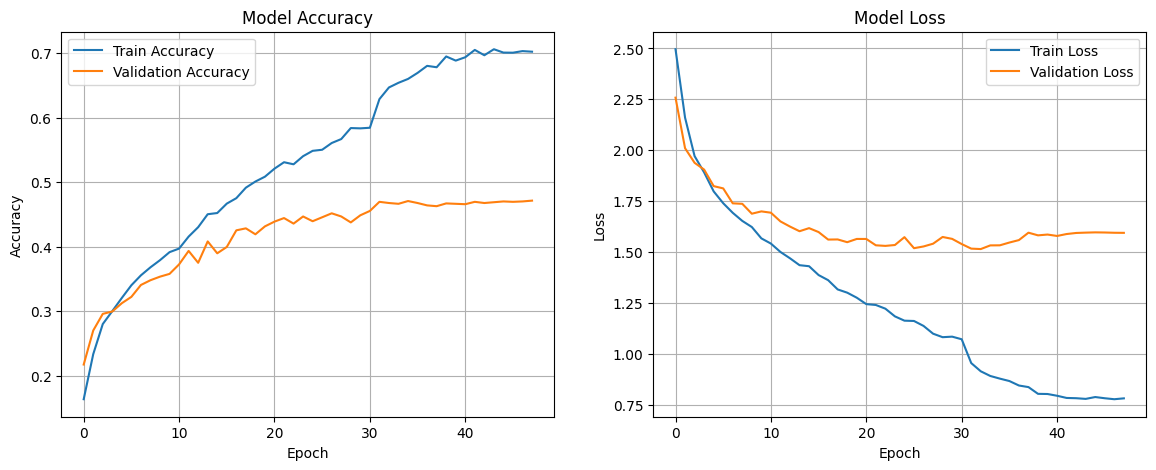

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)

    plt.show()

plot_history(history)

In [23]:
model.save("okayish_model.keras")

In [ ]:
# 71% accuracy for training set hardly touches 50% for test set though!